In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs, make_circles

<h2> Dataset </h2>

In [2]:
data, labels = make_circles(n_samples=1000, random_state=0, noise=0.2, factor=0.3)

# factor is the scaling factor between inner and outer circle
# noise is standard deviation ofthe guassian noise added 

In [3]:
data.shape, labels.shape

((1000, 2), (1000,))

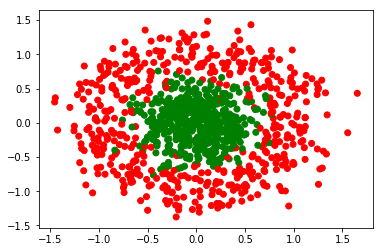

In [4]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=my_cmap)
plt.show()

In [5]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, stratify=labels, random_state=0)
x_train.shape, x_val.shape

((750, 2), (250, 2))

<h2>Feed Forward Network</h2>

In [25]:
class FFNN:
    
    def __init__(self, n_inputs, hidden_sizes=[2]):
        self.nx = n_inputs
        self.ny = 1
        self.nh = len(hidden_sizes)
        self.sizes = [self.nx] + hidden_sizes + [self.ny]
        
        self.W = {}
        self.B = {}
        for i in range(self.nh + 1):
            self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
            self.B[i+1] = np.zeros((1, self.sizes[i+1]))
    
    def sigmoid(self, x):
        return 1.0/(1.0 + np.exp(-x))
    
    def forward_pass(self, x):
        self.A = {}
        self.H = {}
        self.H[0] = x.reshape(1, -1)
        for i in range(self.nh + 1):
            self.A[i + 1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
            self.H[i + 1] = self.sigmoid(self.A[i+1])
        return self.H[self.nh + 1]
    
    def grad_sigmoid(self, x):
        return x * (1 - x)
    
    def grad(self, x, y):
        self.forward_pass(x)
        self.dW = {}
        self.dB = {}
        self.dH = {}
        self.dA = {}
        L = self.nh + 1
        self.dA[L] = (self.H[L] -  y)
        for k in range(L, 0, -1):
            self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
            self.dB[k] = self.dA[k]
            self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
            self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))
#         print(self.dA, self.dB, self.dH, self.dW)
    
    def fit(self, X, Y, epochs=1, learning_rate=1, initialize=True, display_loss=False):
        if initialize:
            for i in range(self.nh + 1):
                self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
                self.B[i+1] = np.zeros((1, self.sizes[i+1]))
        
        if display_loss:
            loss = {}
        
        for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
            dW = {}
            dB = {}
            for i in range(self.nh + 1):
                dW[i + 1] = np.zeros((self.sizes[i], self.sizes[i + 1]))
                dB[i + 1] = np.zeros((1, self.sizes[i + 1]))
            for x, y in zip(X, Y):
                self.grad(x, y)
                for i in range(self.nh + 1):
                    dW[i+1] += self.dW[i+1]
                    dB[i+1] += self.dB[i+1]
            m = X.shape[1]
            for i in range(self.nh + 1):
                self.W[i+1] -= learning_rate * dW[i+1]/m
                self.B[i+1] -= learning_rate * dB[i+1]/m
            
            if display_loss:
                Y_pred = self.predict(X)
                loss[epoch] = mean_squared_error(Y_pred, Y)
        if display_loss:
            plt.plot(loss.values())
            plt.xlabel('Epochs')
            plt.ylabel('Mean Sqaured Error')
            plt.show()
    
    def predict(self, X):
        Y_pred = []
        for x in X:
            y_pred = self.forward_pass(x)
            Y_pred.append(y_pred)
        return np.array(Y_pred).squeeze()

In [12]:
net1 = FFNN(2, [2, 3])

{3: array([[0.6779215]]), 2: array([[ 0.07469005, -0.01569303,  0.17254688]]), 1: array([[-0.04095803, -0.01445257]]), 0: array([[ 0.00071967, -0.00108888]])} {3: array([[0.6779215]]), 2: array([[ 0.07469005, -0.01569303,  0.17254688]]), 1: array([[-0.04095803, -0.01445257]])} {2: array([[ 0.39869777, -0.06277318,  0.87373138]]), 1: array([[-0.33908393, -0.06326285]]), 0: array([[-0.01764852,  0.06365991]])} {3: array([[0.50866468],
       [0.33756001],
       [0.18360391]]), 2: array([[ 0.01049712, -0.00220554,  0.02425015],
       [ 0.04830878, -0.01015009,  0.11160161]]), 1: array([[ 0.00160712,  0.00056709],
       [-0.04164701, -0.01469568]])}
{3: array([[-0.34882025]]), 2: array([[-0.04442111,  0.00806337, -0.07457812]]), 1: array([[0.03694195, 0.0013216 ]]), 0: array([[ 0.0002565, -0.0107833]])} {3: array([[-0.34882025]]), 2: array([[-0.04442111,  0.00806337, -0.07457812]]), 1: array([[0.03694195, 0.0013216 ]])} {2: array([[-0.20514743,  0.03229955, -0.449573  ]]), 1: array([[0.

{3: array([[-0.37692444]]), 2: array([[-0.05270372,  0.00866503, -0.06201801]]), 1: array([[ 0.0279654, -0.0059668]]), 0: array([[0.00058307, 0.03786851]])} {3: array([[-0.37692444]]), 2: array([[-0.05270372,  0.00866503, -0.06201801]]), 1: array([[ 0.0279654, -0.0059668]])} {2: array([[-0.22167601,  0.0349019 , -0.48579476]]), 1: array([[ 0.13532804, -0.02421521]]), 0: array([[ 0.00532377, -0.05314629]])} {3: array([[-0.23017818],
       [-0.20414758],
       [-0.05662646]]), 2: array([[-0.03732526,  0.00613666, -0.04392172],
       [-0.02319267,  0.00381311, -0.02729149]]), 1: array([[ 0.00350115, -0.00074702],
       [-0.01345382,  0.00287055]])}
{3: array([[-0.34866207]]), 2: array([[-0.04502006,  0.00805929, -0.07568746]]), 1: array([[0.03745257, 0.00137707]]), 0: array([[-0.00183907, -0.00995031]])} {3: array([[-0.34866207]]), 2: array([[-0.04502006,  0.00805929, -0.07568746]]), 1: array([[0.03745257, 0.00137707]])} {2: array([[-0.2050544 ,  0.0322849 , -0.44936912]]), 1: array([

{3: array([[-0.36901018]]), 2: array([[-0.0504404 ,  0.00850044, -0.06584856]]), 1: array([[ 0.03314374, -0.00390553]]), 0: array([[0.00057136, 0.02053369]])} {3: array([[-0.36901018]]), 2: array([[-0.0504404 ,  0.00850044, -0.06584856]]), 1: array([[ 0.03314374, -0.00390553]])} {2: array([[-0.21702149,  0.03416906, -0.47559455]]), 1: array([[ 0.14080039, -0.01568612]]), 0: array([[ 0.00765449, -0.06105177]])} {3: array([[-0.23343029],
       [-0.19741561],
       [-0.0612619 ]]), 2: array([[-0.03131593,  0.0052775 , -0.04088209],
       [-0.0236091 ,  0.00397871, -0.03082103]]), 1: array([[ 0.00269273, -0.0003173 ],
       [-0.00880707,  0.00103779]])}
{3: array([[0.61221648]]), 2: array([[ 0.08818619, -0.01402463,  0.09111469]]), 1: array([[-0.0291165,  0.0130105]]), 0: array([[-0.00027736, -0.09661485]])} {3: array([[0.61221648]]), 2: array([[ 0.08818619, -0.01402463,  0.09111469]]), 1: array([[-0.0291165,  0.0130105]])} {2: array([[ 0.36005547, -0.05668912,  0.78904822]]), 1: array

       [-0.00450303,  0.00024258]])}
{3: array([[0.66392919]]), 2: array([[ 0.08779731, -0.01535966,  0.16649652]]), 1: array([[-0.06967731, -0.00804669]]), 0: array([[0.04695678, 0.02621268]])} {3: array([[0.66392919]]), 2: array([[ 0.08779731, -0.01535966,  0.16649652]]), 1: array([[-0.06967731, -0.00804669]])} {2: array([[ 0.39046864, -0.06147754,  0.85569754]]), 1: array([[-0.33491839, -0.03260851]]), 0: array([[-0.02299762,  0.11840899]])} {3: array([[0.43725314],
       [0.34031635],
       [0.1756576 ]]), 2: array([[ 0.0259147 , -0.00453363,  0.04914396],
       [ 0.03890629, -0.00680644,  0.07378086]]), 1: array([[ 0.07064391,  0.00815832],
       [-0.02304982, -0.00266191]])}
{3: array([[-0.3438571]]), 2: array([[-0.04380185,  0.0079521 , -0.07772596]]), 1: array([[0.03642419, 0.0025147 ]]), 0: array([[-0.00293917, -0.01293584]])} {3: array([[-0.3438571]]), 2: array([[-0.04380185,  0.0079521 , -0.07772596]]), 1: array([[0.03642419, 0.0025147 ]])} {2: array([[-0.20222851,  0.03

       [0.0037586 , 0.00010761]])}
{3: array([[-0.34417162]]), 2: array([[-0.04309074,  0.00795975, -0.07642128]]), 1: array([[0.03588563, 0.00244149]]), 0: array([[-0.00012299, -0.01345078]])} {3: array([[-0.34417162]]), 2: array([[-0.04309074,  0.00795975, -0.07642128]]), 1: array([[0.03588563, 0.00244149]])} {2: array([[-0.20241349,  0.0318691 , -0.44358166]]), 1: array([[0.15534299, 0.00985411]]), 0: array([[ 0.01112107, -0.06202468]])} {3: array([[-0.23839161],
       [-0.17737541],
       [-0.07613802]]), 2: array([[-0.01560713,  0.00288296, -0.02767919],
       [-0.02358323,  0.00435631, -0.04182477]]), 1: array([[-3.92576944e-04, -2.67090837e-05],
       [ 1.14102259e-02,  7.76297953e-04]])}
{3: array([[0.61697628]]), 2: array([[ 0.08638872, -0.01415724,  0.09064216]]), 1: array([[-0.03394128,  0.01301143]]), 0: array([[-0.00099507, -0.07351545]])} {3: array([[0.61697628]]), 2: array([[ 0.08638872, -0.01415724,  0.09064216]]), 1: array([[-0.03394128,  0.01301143]])} {2: array([

{3: array([[-0.36708691]]), 2: array([[-0.0484768 ,  0.00846119, -0.06357715]]), 1: array([[ 0.03246095, -0.00367729]]), 0: array([[0.00188939, 0.01120905]])} {3: array([[-0.36708691]]), 2: array([[-0.0484768 ,  0.00846119, -0.06357715]]), 1: array([[ 0.03246095, -0.00367729]])} {2: array([[-0.21589038,  0.03399098, -0.47311577]]), 1: array([[ 0.13590606, -0.01475958]]), 0: array([[ 0.00755958, -0.05970371]])} {3: array([[-0.24211242],
       [-0.19558128],
       [-0.05872295]]), 2: array([[-0.02935759,  0.0051241 , -0.03850238],
       [-0.0256552 ,  0.00447788, -0.0336467 ]]), 1: array([[ 0.01649446, -0.00186855],
       [-0.00524643,  0.00059433]])}
{3: array([[-0.35042714]]), 2: array([[-0.04457327,  0.00809923, -0.07340657]]), 1: array([[0.03687574, 0.000914  ]]), 0: array([[ 0.00109378, -0.0099153 ]])} {3: array([[-0.35042714]]), 2: array([[-0.04457327,  0.00809923, -0.07340657]]), 1: array([[0.03687574, 0.000914  ]])} {2: array([[-0.20609247,  0.03244834, -0.45164402]]), 1: arr

{3: array([[0.62080062]]), 2: array([[ 0.08993039, -0.01425871,  0.11061656]]), 1: array([[-0.04863714,  0.00787846]]), 0: array([[ 0.01388211, -0.09599965]])} {3: array([[0.62080062]]), 2: array([[ 0.08993039, -0.01425871,  0.11061656]]), 1: array([[-0.04863714,  0.00787846]])} {2: array([[ 0.36510395, -0.05748399,  0.80011178]]), 1: array([[-0.23905219,  0.03574161]]), 0: array([[-0.01032055,  0.09090378]])} {3: array([[0.34808819],
       [0.33783707],
       [0.10287398]]), 2: array([[ 0.06436636, -0.01020547,  0.07917219],
       [ 0.02950032, -0.00467736,  0.03628612]]), 1: array([[ 0.03710869, -0.00601103],
       [ 0.03126536, -0.0050645 ]])}
{3: array([[-0.36796698]]), 2: array([[-0.04937358,  0.00847921, -0.06452937]]), 1: array([[ 0.03274187, -0.00382019]]), 0: array([[0.00165711, 0.01516199]])} {3: array([[-0.36796698]]), 2: array([[-0.04937358,  0.00847921, -0.06452937]]), 1: array([[ 0.03274187, -0.00382019]])} {2: array([[-0.21640797,  0.03407247, -0.47425004]]), 1: arra

{3: array([[0.62789098]]), 2: array([[ 0.08298738, -0.01445606,  0.09964091]]), 1: array([[-0.04807278,  0.00890184]]), 0: array([[-0.00152476, -0.03063346]])} {3: array([[0.62789098]]), 2: array([[ 0.08298738, -0.01445606,  0.09964091]]), 1: array([[-0.04807278,  0.00890184]])} {2: array([[ 0.36927392, -0.05814053,  0.80925011]]), 1: array([[-0.21675161,  0.03589286]]), 0: array([[-0.00972725,  0.09053051]])} {3: array([[0.413756  ],
       [0.33710105],
       [0.09029593]]), 2: array([[ 0.05543275, -0.00965616,  0.06655675],
       [ 0.04519424, -0.00787265,  0.05426361]]), 1: array([[-0.03871623,  0.00716925],
       [ 0.01283819, -0.0023773 ]])}
{3: array([[0.60698114]]), 2: array([[ 0.08890005, -0.01387773,  0.0912513 ]]), 1: array([[-0.02284943,  0.01189723]]), 0: array([[ 0.00056925, -0.11566064]])} {3: array([[0.60698114]]), 2: array([[ 0.08890005, -0.01387773,  0.0912513 ]]), 1: array([[-0.02284943,  0.01189723]])} {2: array([[ 0.35697647, -0.05620435,  0.78230071]]), 1: arra

{3: array([[-0.37267647]]), 2: array([[-0.04957838,  0.00857877, -0.05924271]]), 1: array([[ 0.02837188, -0.00541609]]), 0: array([[0.00108143, 0.02006924]])} {3: array([[-0.37267647]]), 2: array([[-0.04957838,  0.00857877, -0.05924271]]), 1: array([[ 0.02837188, -0.00541609]])} {2: array([[-0.2191777 ,  0.03450855, -0.48031981]]), 1: array([[ 0.12898331, -0.02176805]]), 0: array([[ 0.00567192, -0.0535291 ]])} {3: array([[-0.24382982],
       [-0.20029026],
       [-0.05370527]]), 2: array([[-0.03338135,  0.00577613, -0.03988838],
       [-0.0265001 ,  0.00458543, -0.03166577]]), 1: array([[ 0.02109705, -0.00402735],
       [-0.0082426 ,  0.00157348]])}
{3: array([[-0.36312482]]), 2: array([[-0.04815741,  0.00837598, -0.06738666]]), 1: array([[ 0.0350829 , -0.00244259]]), 0: array([[0.00155081, 0.00682502]])} {3: array([[-0.36312482]]), 2: array([[-0.04815741,  0.00837598, -0.06738666]]), 1: array([[ 0.0350829 , -0.00244259]])} {2: array([[-0.2135602 ,  0.0336241 , -0.46800927]]), 1: a

{3: array([[0.61076077]]), 2: array([[ 0.08745641, -0.01398333,  0.08563573]]), 1: array([[-0.02410847,  0.0145529 ]]), 0: array([[-0.00014805, -0.09196926]])} {3: array([[0.61076077]]), 2: array([[ 0.08745641, -0.01398333,  0.08563573]]), 1: array([[-0.02410847,  0.0145529 ]])} {2: array([[ 0.35919934, -0.05655433,  0.78717204]]), 1: array([[-0.1945865 ,  0.06011902]]), 0: array([[-0.00059274,  0.0515686 ]])} {3: array([[0.35471243],
       [0.33738145],
       [0.07586846]]), 2: array([[ 0.07478497, -0.0119573 ,  0.07322809],
       [ 0.03593923, -0.00574629,  0.03519104]]), 1: array([[-0.01169201,  0.0070578 ],
       [ 0.02232409, -0.01347577]])}
{3: array([[0.68074812]]), 2: array([[ 0.08212234, -0.01575872,  0.18374881]]), 1: array([[-0.04232359, -0.01560761]]), 0: array([[0.03406389, 0.00595717]])} {3: array([[0.68074812]]), 2: array([[ 0.08212234, -0.01575872,  0.18374881]]), 1: array([[-0.04232359, -0.01560761]])} {2: array([[ 0.40036015, -0.06303492,  0.87737444]]), 1: array(

{3: array([[-0.33449957]]), 2: array([[-0.03973694,  0.00774154, -0.07909878]]), 1: array([[0.03081165, 0.00459681]]), 0: array([[ 0.00034786, -0.01258047]])} {3: array([[-0.33449957]]), 2: array([[-0.03973694,  0.00774154, -0.07909878]]), 1: array([[0.03081165, 0.00459681]])} {2: array([[-0.19672518,  0.0309735 , -0.43111595]]), 1: array([[0.15827567, 0.01902533]]), 0: array([[ 0.01061081, -0.05172615]])} {3: array([[-0.24054098],
       [-0.16982488],
       [-0.08097386]]), 2: array([[-0.01052148,  0.00204979, -0.02094365],
       [-0.0235071 ,  0.00457965, -0.04679231]]), 1: array([[0.00104558, 0.00015599],
       [0.0179442 , 0.00267711]])}
{3: array([[0.66788958]]), 2: array([[ 0.07462078, -0.01545993,  0.1562713 ]]), 1: array([[-0.05561237, -0.01006107]]), 0: array([[-0.00492836,  0.01759148]])} {3: array([[0.66788958]]), 2: array([[ 0.07462078, -0.01545993,  0.1562713 ]]), 1: array([[-0.05561237, -0.01006107]])} {2: array([[ 0.39279782, -0.06184426,  0.86080186]]), 1: array([[-

{3: array([[0.66952473]]), 2: array([[ 0.07390624, -0.01549839,  0.15823545]]), 1: array([[-0.05320172, -0.01072638]]), 0: array([[-0.00484891,  0.0139691 ]])} {3: array([[0.66952473]]), 2: array([[ 0.07390624, -0.01549839,  0.15823545]]), 1: array([[-0.05320172, -0.01072638]])} {2: array([[ 0.39375947, -0.06199567,  0.8629093 ]]), 1: array([[-0.31390803, -0.04815497]]), 0: array([[-0.01950622,  0.08760911]])} {3: array([[0.50188375],
       [0.33671978],
       [0.16194503]]), 2: array([[ 0.01598169, -0.00335142,  0.03421728],
       [ 0.04915388, -0.01030773,  0.10523991]]), 1: array([[-0.02459791, -0.00495936],
       [-0.04261025, -0.00859096]])}
{3: array([[0.66727551]]), 2: array([[ 0.07580739, -0.01544519,  0.15654845]]), 1: array([[-0.05715981, -0.0098631 ]]), 0: array([[-0.00454484,  0.01997669]])} {3: array([[0.66727551]]), 2: array([[ 0.07580739, -0.01544519,  0.15654845]]), 1: array([[-0.05715981, -0.0098631 ]])} {2: array([[ 0.39243667, -0.0617874 ,  0.86001042]]), 1: arra

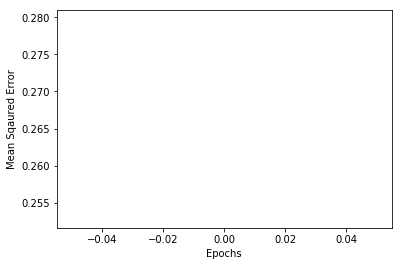

In [13]:
net1.fit(x_train, y_train, epochs=1, learning_rate=0.001, display_loss=True)

In [14]:
net1.nh

2

In [15]:
net1.sizes

[2, 2, 3, 1]

In [16]:
net1.dW

{3: array([[0.42367017],
        [0.33704124],
        [0.09832243]]), 2: array([[ 0.05014171, -0.00888084,  0.06515726],
        [ 0.04568048, -0.00809069,  0.05936007]]), 1: array([[-0.0389163 ,  0.00461938],
        [ 0.00745942, -0.00088544]])}

In [17]:
net1.dB

{3: array([[0.63288596]]),
 2: array([[ 0.08236852, -0.01458868,  0.1070348 ]]),
 1: array([[-0.05460578,  0.00648173]])}

In [18]:
net1.dH

{2: array([[ 0.37221156, -0.05860305,  0.81568783]]),
 1: array([[-0.22926866,  0.02623967]]),
 0: array([[-0.01259106,  0.10061436]])}

In [19]:
net1.dA

{3: array([[0.63288596]]),
 2: array([[ 0.08236852, -0.01458868,  0.1070348 ]]),
 1: array([[-0.05460578,  0.00648173]]),
 0: array([[-0.00257825, -0.01562198]])}

In [20]:
net1.W

{1: array([[ 0.28032095,  0.42445037],
        [-1.76880347,  0.61258575]]),
 2: array([[-0.49049412,  0.28206703, -1.73236835],
        [ 1.80387767, -0.07330753, -1.16186235]]),
 3: array([[ 0.55224963],
        [-0.12059526],
        [ 1.27706541]])}

In [21]:
net1.H

{0: array([[ 0.7126773 , -0.13660502]]),
 1: array([[0.60919085, 0.55454821]]),
 2: array([[0.66704914, 0.53305642, 0.15302575]]),
 3: array([[0.60962535]])}

In [22]:
net1.B

{1: array([[0.00250645, 0.00025087]]),
 2: array([[-0.00666379,  0.00123875, -0.01141241]]),
 3: array([[-0.05377981]])}

In [23]:
net1.A

{1: array([[0.44391227, 0.21906473]]),
 2: array([[ 0.69486882,  0.13241884, -1.71106405]]),
 3: array([[0.44573765]])}

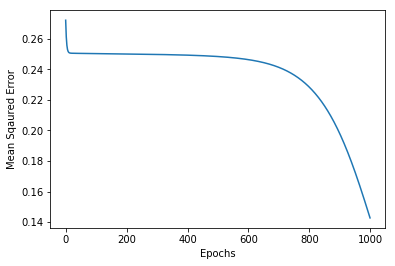

In [26]:
net1 = FFNN(2, [3, 3])
net1.fit(x_train, y_train, epochs=1000, learning_rate=0.001, display_loss=True)

In [28]:
y_pred_train = net1.predict(x_train)
y_pred_binarized_train = (y_pred_train >= 0.5).astype("int").ravel()
y_pred_val = net1.predict(x_val)
y_pred_binarized_val = (y_pred_val >= 0.5).astype("int").ravel()

acc_train = accuracy_score(y_pred_binarized_train, y_train)
acc_val = accuracy_score(y_pred_binarized_val, y_val)

print("Train acc", round(acc_train, 2))
print("Validation acc", round(acc_val, 2))

Train acc 0.92
Validation acc 0.92


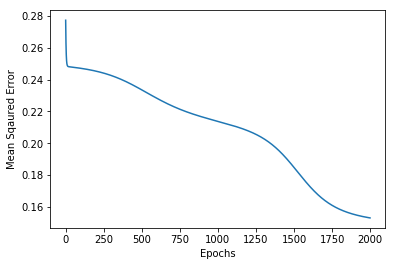

In [30]:
# training 1000 more epochs
net1.fit(x_train, y_train, epochs=2000, learning_rate=0.001, display_loss=True)

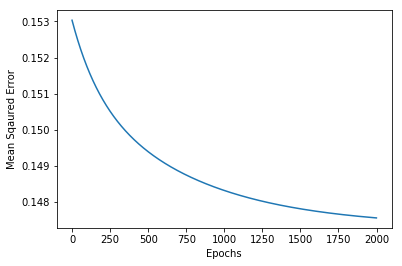

In [31]:
net1.fit(x_train, y_train, epochs=2000, initialize=False, learning_rate=0.001, display_loss=True)

In [32]:
y_pred_train = net1.predict(x_train)
y_pred_binarized_train = (y_pred_train >= 0.5).astype("int").ravel()
y_pred_val = net1.predict(x_val)
y_pred_binarized_val = (y_pred_val >= 0.5).astype("int").ravel()

acc_train = accuracy_score(y_pred_binarized_train, y_train)
acc_val = accuracy_score(y_pred_binarized_val, y_val)

print("Train acc", round(acc_train, 2))
print("Validation acc", round(acc_val, 2))

Train acc 0.81
Validation acc 0.81


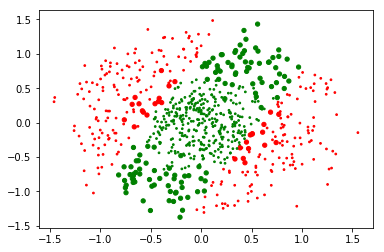

In [33]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_pred_binarized_train, cmap=my_cmap, s=15*(np.abs(y_pred_binarized_train - y_train) + 0.2))
plt.show()

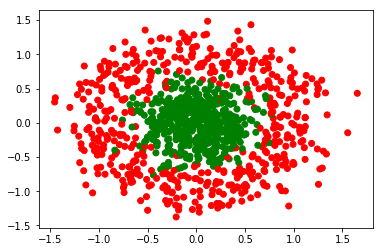

In [34]:
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=my_cmap)
plt.show()

<h2>plotting sigmoid surface</h2>

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [46]:
# y_pred_train.shape,x_train[:, 0].shape, x_train[:, 1].shape, y_train.shape
y_tmp = np.reshape(y_pred_train, (-1, y_pred_train.shape[0]))
y_tmp.shape

(1, 750)

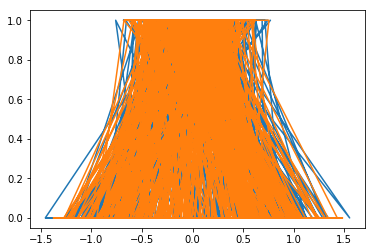

In [72]:
# fig = plt.figure(figsize=(9, 6))
# ax = plt.axes(projection='3d')
# ax.plot_surface(x_train[:, 0], x_train[:, 1], y_tmp, cmap="viridis")
# ax.set_xlabel('x1')
# ax.set_ylabel('x2')
# ax.set_zlabel('y')

# ax.view_init(30, 270)

# plt.contourf(x_train[:, 0], x_train[:, 1], y_train, cmap=my_cmap, alpha=0.6)
# plt.show()
plt.plot(x_train, y_train)
plt.show()

<h2>plotting Loss surface</h2>

In [6]:
class FFNN2:
    
    def __init__(self, n_inputs, hidden_sizes=[2]):
        self.nx = n_inputs
        self.ny = 1
        self.nh = len(hidden_sizes)
        self.sizes = [self.nx] + hidden_sizes + [self.ny]
        self.loss = {}
        
        self.W = {}
        self.B = {}
        for i in range(self.nh + 1):
            self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
            self.B[i+1] = np.zeros((1, self.sizes[i+1]))
    
    def sigmoid(self, x):
        return 1.0/(1.0 + np.exp(-x))
    
    def forward_pass(self, x):
        self.A = {}
        self.H = {}
        self.H[0] = x.reshape(1, -1)
        for i in range(self.nh + 1):
            self.A[i + 1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
            self.H[i + 1] = self.sigmoid(self.A[i+1])
        return self.H[self.nh + 1]
    
    def grad_sigmoid(self, x):
        return x * (1 - x)
    
    def grad(self, x, y):
        self.forward_pass(x)
        self.dW = {}
        self.dB = {}
        self.dH = {}
        self.dA = {}
        L = self.nh + 1
        self.dA[L] = (self.H[L] -  y)
        for k in range(L, 0, -1):
            self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
            self.dB[k] = self.dA[k]
            self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
            self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))
#         print(self.dA, self.dB, self.dH, self.dW)
    
    def fit(self, X, Y, epochs=1, learning_rate=1, initialize=True, display_loss=False):
        if initialize:
            for i in range(self.nh + 1):
                self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
                self.B[i+1] = np.zeros((1, self.sizes[i+1]))
        
        if display_loss:
            self.loss = {}
        
        for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
            dW = {}
            dB = {}
            for i in range(self.nh + 1):
                dW[i + 1] = np.zeros((self.sizes[i], self.sizes[i + 1]))
                dB[i + 1] = np.zeros((1, self.sizes[i + 1]))
            for x, y in zip(X, Y):
                self.grad(x, y)
                for i in range(self.nh + 1):
                    dW[i+1] += self.dW[i+1]
                    dB[i+1] += self.dB[i+1]
            m = X.shape[1]
            for i in range(self.nh + 1):
                self.W[i+1] -= learning_rate * dW[i+1]/m
                self.B[i+1] -= learning_rate * dB[i+1]/m
            
            if display_loss:
                Y_pred = self.predict(X)
                self.loss[epoch] = mean_squared_error(Y_pred, Y)
        if display_loss:
            plt.plot(self.loss.values())
            plt.xlabel('Epochs')
            plt.ylabel('Mean Sqaured Error')
            plt.show()
    
    def predict(self, X):
        Y_pred = []
        for x in X:
            y_pred = self.forward_pass(x)
            Y_pred.append(y_pred)
        return np.array(Y_pred).squeeze()

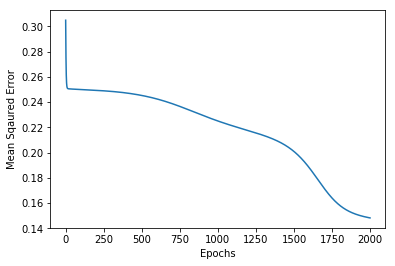

In [7]:
net2 = FFNN2(2, [3, 3])
net2.fit(x_train, y_train, epochs=2000, learning_rate=0.001, display_loss=True)

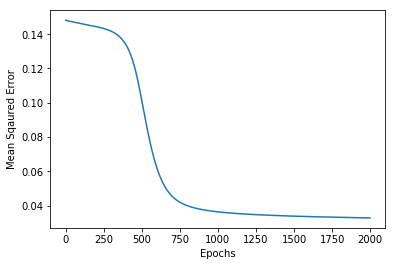

In [8]:
net2.fit(x_train, y_train, epochs=2000, initialize=False, learning_rate=0.001, display_loss=True)

In [10]:
y_pred_train = net2.predict(x_train)
y_pred_binarized_train = (y_pred_train >= 0.5).astype("int").ravel()
y_pred_val = net2.predict(x_val)
y_pred_binarized_val = (y_pred_val >= 0.5).astype("int").ravel()

acc_train = accuracy_score(y_pred_binarized_train, y_train)
acc_val = accuracy_score(y_pred_binarized_val, y_val)

print("Train acc", round(acc_train, 2))
print("Validation acc", round(acc_val, 2))

Train acc 0.96
Validation acc 0.94


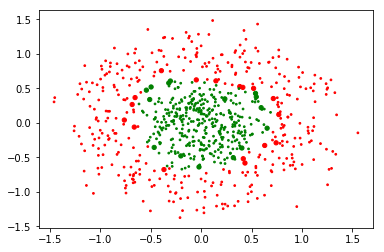

In [11]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_pred_binarized_train, cmap=my_cmap, s=15*(np.abs(y_pred_binarized_train - y_train) + 0.2))
plt.show()

In [14]:
x_train[:, 0].shape, x_train[:, 1].shape

((750,), (750,))

In [17]:
l = list(net2.loss.values())
len(l)

2000

In [63]:
# reshape the plot to transform x, y and z in 2d array
# error_surface = np.reshape(np.array(l[:500]), (250, 2))
# error_surface.shape
error_surface = np.meshgrid(np.array(l[:250]), indexing='ij')

In [65]:
error_surface = np.asarray(error_surface)
error_surface.shape

(1, 250)

In [78]:
_X1, _X2 = np.meshgrid(x_train[:250, 0], x_train[:250, 1], indexing='ij')

In [79]:
_X1.shape, _X2.shape, error_surface.shape

((250, 250), (250, 250), (1, 250))

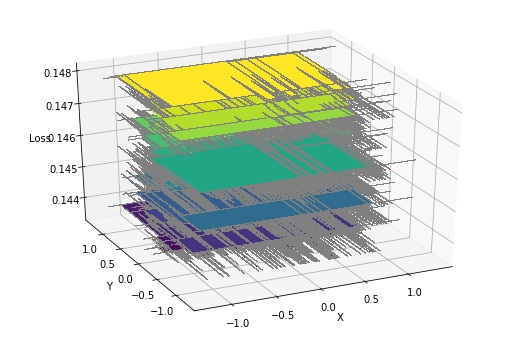

In [80]:
fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
ax.plot_surface(_X, _Y, error_surface, cmap='viridis', edgecolor='gray', linewidth=0.004, antialiased=False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Loss')
ax.view_init(30, 245)
plt.show()

In [81]:
_X1, _X2 = np.meshgrid(x_val[:250, 0], x_val[:250, 1], indexing='ij')

In [82]:
y_tmp = np.reshape(y_val, (-1, 250))
y_tmp.shape

(1, 250)

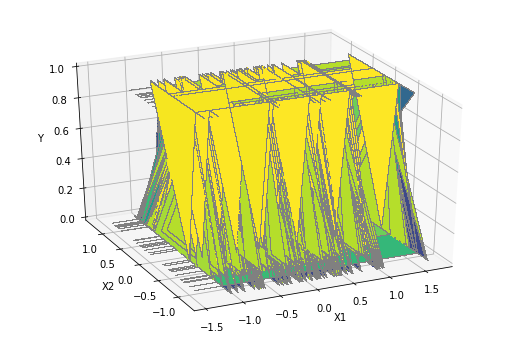

In [83]:
fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
ax.plot_surface(_X1, _X2, y_tmp, cmap='viridis', edgecolor='gray', linewidth=0.004, antialiased=False)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.view_init(30, 245)
plt.show()